# Notebook 7: Balanço de Massa com Bandas de Incerteza

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
Realizar a análise de balanço de massa do distrito, verificando se a diferença entre entrada e saída está dentro das bandas de incerteza.

### Conceitos-chave

**Balanço de massa:** Em um sistema de distribuição, a massa (ou volume) que entra deve ser igual à que sai, descontadas as perdas.

$$\text{Diferença (\%)} = \frac{\text{Entrada} - \sum \text{Saídas}}{\text{Entrada}} \times 100$$

**Banda de variação com incerteza:**
- $V_{min} = V_{medido} \times (1 - U\%)$
- $V_{max} = V_{medido} \times (1 + U\%)$

**Critério de aceitação:** Se as bandas de entrada e saída se sobrepõem, o balanço é considerado **aceitável** (a diferença pode ser explicada pelas incertezas de medição).

## Configuração do Google Colab

Este notebook foi adaptado para rodar no **Google Colab**.

**Pré-requisito:** Coloque o arquivo Excel na pasta do Google Drive:
```
Google Drive / ABAR / data / Analise de Condições de Operação de Distrito.xlsx
```

> Se o arquivo estiver em outra pasta, altere `DRIVE_DATA_DIR` na célula abaixo.

In [ ]:
# === CONFIGURAÇÃO GOOGLE COLAB ===
# Monte o Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os

# Pasta no Google Drive onde está o arquivo Excel
# Ajuste se necessário:
DRIVE_DATA_DIR = Path('/content/drive/MyDrive/ABAR/data')

# Pasta para salvar gráficos (no Colab)
GRAFICOS_DIR = Path('/content/graficos')
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

EXCEL_DEFAULT = 'Analise de Condições de Operação de Distrito.xlsx'
EXCEL_PATH = DRIVE_DATA_DIR / EXCEL_DEFAULT

# Verificar se o arquivo existe
if EXCEL_PATH.exists():
    print(f'Arquivo encontrado: {EXCEL_PATH}')
    print(f'Tamanho: {EXCEL_PATH.stat().st_size / 1024:.0f} KB')
else:
    print(f'ERRO: Arquivo não encontrado em {EXCEL_PATH}')
    print(f'Conteúdo de {DRIVE_DATA_DIR}:')
    if DRIVE_DATA_DIR.exists():
        for f in DRIVE_DATA_DIR.iterdir():
            print(f'  {f.name}')
    else:
        print(f'  Pasta não existe! Crie: {DRIVE_DATA_DIR}')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações gerais
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:,.2f}'.format)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print('Bibliotecas carregadas com sucesso!')


## 1. Carregamento dos Dados e Volumes Totais

In [2]:
# Clientes e seus volumes (carregados das abas)
CLIENTES = {
    'Cliente #1': 'Empresa A',
    'Cliente #2': 'Empresa B',
    'Cliente #3': 'Empresa C',
    'Cliente #4': 'Empresa D',
    'Cliente #5': 'Empresa E',
    'Cliente #6': 'Empresa F',
    'Cliente #7': 'Empresa G'
}

# Volume de referência para clientes sem dados horários (da Planilha1)
VOLUMES_REFERENCIA = {
    'Empresa D': 88184  # Nm³ total no período
}

# Carregar volume de entrada
df_vol = pd.read_excel(EXCEL_PATH, sheet_name='Vol Entrada Gas', header=1, usecols='B:D')
df_vol.columns = ['Data', 'Vol_Conc', 'Vol_Transp']
df_vol['Data'] = pd.to_datetime(df_vol['Data'], errors='coerce')
for col in ['Vol_Conc', 'Vol_Transp']:
    df_vol[col] = pd.to_numeric(df_vol[col], errors='coerce')
df_vol = df_vol.dropna(subset=['Data'])
vol_entrada = df_vol['Vol_Conc'].sum()

# Carregar volumes por cliente
volumes_clientes = {}
for aba, nome in CLIENTES.items():
    df = pd.read_excel(EXCEL_PATH, sheet_name=aba, header=2, usecols='B:C')
    df.columns = ['Data', 'Volume_Nm3h']
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    df['Volume_Nm3h'] = pd.to_numeric(df['Volume_Nm3h'], errors='coerce')
    df = df.dropna(subset=['Data'])
    
    vol = df['Volume_Nm3h'].sum()
    if vol == 0 or pd.isna(vol):
        vol = VOLUMES_REFERENCIA.get(nome, 0)
        print(f'  AVISO: {nome} sem dados horários -> usando referência: {vol:,.0f} Nm³')
    volumes_clientes[nome] = vol

vol_saida_total = sum(volumes_clientes.values())

print('=== VOLUMES DO PERÍODO ===')
print(f'Entrada (Concessionária): {vol_entrada:>20,.0f} Nm³')
print(f'\nSaídas:')
for nome, vol in volumes_clientes.items():
    pct = vol / vol_saida_total * 100
    print(f'  {nome:<25} {vol:>15,.0f} Nm³ ({pct:5.1f}%)')
print(f'  {"-"*25} {"-"*15}')
print(f'  {"TOTAL SAÍDAS":<25} {vol_saida_total:>15,.0f} Nm³')

diferenca = vol_entrada - vol_saida_total
diferenca_pct = (diferenca / vol_entrada) * 100
print(f'\nDiferença: {diferenca:>20,.0f} Nm³ ({diferenca_pct:.2f}%)')

=== VOLUMES DO PERÍODO ===
Entrada (Concessionária):          182,919,850 Nm³

Saídas:
  Empresa A                   104,104,553 Nm³ ( 57.5%)
  Empresa B            43,664,475 Nm³ ( 24.1%)
  Empresa C               6,841,747 Nm³ (  3.8%)
  Empresa D                         88,184 Nm³ (  0.0%)
  Empresa E           10,184,645 Nm³ (  5.6%)
  Empresa F                     5,957,912 Nm³ (  3.3%)
  Empresa G                   10,081,924 Nm³ (  5.6%)
  ------------------------- ---------------
  TOTAL SAÍDAS                  180,923,440 Nm³

Diferença:            1,996,410 Nm³ (1.09%)


## 2. Incertezas e Bandas de Variação

Usando os valores de incerteza calculados no Notebook 6.

In [3]:
# Incertezas por ponto (valores de vazão normal, da aba Incertezas)
incertezas_clientes = {
    'Empresa A': 0.0133,
    'Empresa B': 0.0161,
    'Empresa C': 0.0134,
    'Empresa D': 0.0358,
    'Empresa E': 0.0305,
    'Empresa F': 0.0148,
    'Empresa G': 0.028
}

# Incerteza combinada da entrada (RSS de 2 tramos)
# Tramo 101: 0.0106, Tramo 501: 0.0109 (aba Incertezas, fórmula =SQRT(G7^2+G11^2))
u_entrada = np.sqrt(0.0106**2 + 0.0109**2)

# Incerteza combinada das saídas (RSS de todos os clientes)
u_saida = np.sqrt(sum(v**2 for v in incertezas_clientes.values()))

print(f'Incerteza combinada da entrada: {u_entrada*100:.2f}%')
print(f'Incerteza combinada das saídas: {u_saida*100:.2f}%')

Incerteza combinada da entrada: 1.52%
Incerteza combinada das saídas: 6.19%


In [4]:
# Calcular bandas de variação
entrada_min = vol_entrada * (1 - u_entrada)
entrada_max = vol_entrada * (1 + u_entrada)

saida_min = vol_saida_total * (1 - u_saida)
saida_max = vol_saida_total * (1 + u_saida)

print('=== BANDAS DE VARIAÇÃO COM INCERTEZA ===')
print(f'\nENTRADA:')
print(f'  Valor medido: {vol_entrada:>20,.0f} Nm³')
print(f'  Incerteza:    {u_entrada*100:>20.2f}%')
print(f'  Banda mínima: {entrada_min:>20,.0f} Nm³')
print(f'  Banda máxima: {entrada_max:>20,.0f} Nm³')

print(f'\nSAÍDA:')
print(f'  Valor medido: {vol_saida_total:>20,.0f} Nm³')
print(f'  Incerteza:    {u_saida*100:>20.2f}%')
print(f'  Banda mínima: {saida_min:>20,.0f} Nm³')
print(f'  Banda máxima: {saida_max:>20,.0f} Nm³')

=== BANDAS DE VARIAÇÃO COM INCERTEZA ===

ENTRADA:
  Valor medido:          182,919,850 Nm³
  Incerteza:                    1.52%
  Banda mínima:          180,138,686 Nm³
  Banda máxima:          185,701,014 Nm³

SAÍDA:
  Valor medido:          180,923,440 Nm³
  Incerteza:                    6.19%
  Banda mínima:          169,725,770 Nm³
  Banda máxima:          192,121,110 Nm³


In [5]:
# Bandas por cliente
print('=== BANDAS POR CLIENTE ===')
print(f'{"Cliente":<25} {"Volume (Nm³)":>15} {"Incerteza":>10} {"Banda Min":>15} {"Banda Max":>15}')
print('-' * 85)

bandas_clientes = {}
for nome in volumes_clientes:
    vol = volumes_clientes[nome]
    inc = incertezas_clientes[nome]
    v_min = vol * (1 - inc)
    v_max = vol * (1 + inc)
    bandas_clientes[nome] = {'vol': vol, 'inc': inc, 'min': v_min, 'max': v_max}
    print(f'{nome:<25} {vol:>15,.0f} {inc*100:>9.2f}% {v_min:>15,.0f} {v_max:>15,.0f}')

# Totais das saídas
soma_min = sum(b['min'] for b in bandas_clientes.values())
soma_max = sum(b['max'] for b in bandas_clientes.values())
print('-' * 85)
print(f'{"TOTAL":<25} {vol_saida_total:>15,.0f} {u_saida*100:>9.2f}% {soma_min:>15,.0f} {soma_max:>15,.0f}')

=== BANDAS POR CLIENTE ===
Cliente                      Volume (Nm³)  Incerteza       Banda Min       Banda Max
-------------------------------------------------------------------------------------
Empresa A                   104,104,553      1.33%     102,719,962     105,489,144
Empresa B            43,664,475      1.61%      42,961,477      44,367,473
Empresa C               6,841,747      1.34%       6,750,068       6,933,426
Empresa D                         88,184      3.58%          85,027          91,341
Empresa E           10,184,645      3.05%       9,874,013      10,495,277
Empresa F                     5,957,912      1.48%       5,869,735       6,046,089
Empresa G                   10,081,924      2.80%       9,799,630      10,364,218
-------------------------------------------------------------------------------------
TOTAL                         180,923,440      6.19%     178,059,912     183,786,968


## 3. Verificação de Sobreposição das Bandas

**Critério:** Se as bandas de entrada e saída se sobrepõem, a diferença observada pode ser explicada pelas incertezas de medição → balanço **aceitável**.

In [6]:
# Verificar sobreposição
sobrepoe = entrada_min <= saida_max and saida_min <= entrada_max

print('=== ANÁLISE DE SOBREPOSIÇÃO ===')
print(f'\nBanda da Entrada:  [{entrada_min:,.0f}  —  {entrada_max:,.0f}]')
print(f'Banda das Saídas:  [{saida_min:,.0f}  —  {saida_max:,.0f}]')
print(f'\nHá sobreposição? {"SIM" if sobrepoe else "NÃO"}')

if sobrepoe:
    # Calcular a região de sobreposição
    overlap_min = max(entrada_min, saida_min)
    overlap_max = min(entrada_max, saida_max)
    print(f'Região de sobreposição: [{overlap_min:,.0f}  —  {overlap_max:,.0f}]')
    print(f'\nRESULTADO: BALANÇO ACEITÁVEL')
    print(f'A diferença de {diferenca_pct:.2f}% está dentro das incertezas de medição.')
else:
    print(f'\nRESULTADO: BALANÇO NÃO ACEITÁVEL')
    print(f'A diferença não pode ser explicada apenas pelas incertezas de medição.')

=== ANÁLISE DE SOBREPOSIÇÃO ===

Banda da Entrada:  [180,138,686  —  185,701,014]
Banda das Saídas:  [169,725,770  —  192,121,110]

Há sobreposição? SIM
Região de sobreposição: [180,138,686  —  185,701,014]

RESULTADO: BALANÇO ACEITÁVEL
A diferença de 1.09% está dentro das incertezas de medição.


## 4. Gráficos

### 4.1 Entrada vs Saída com Bandas de Incerteza

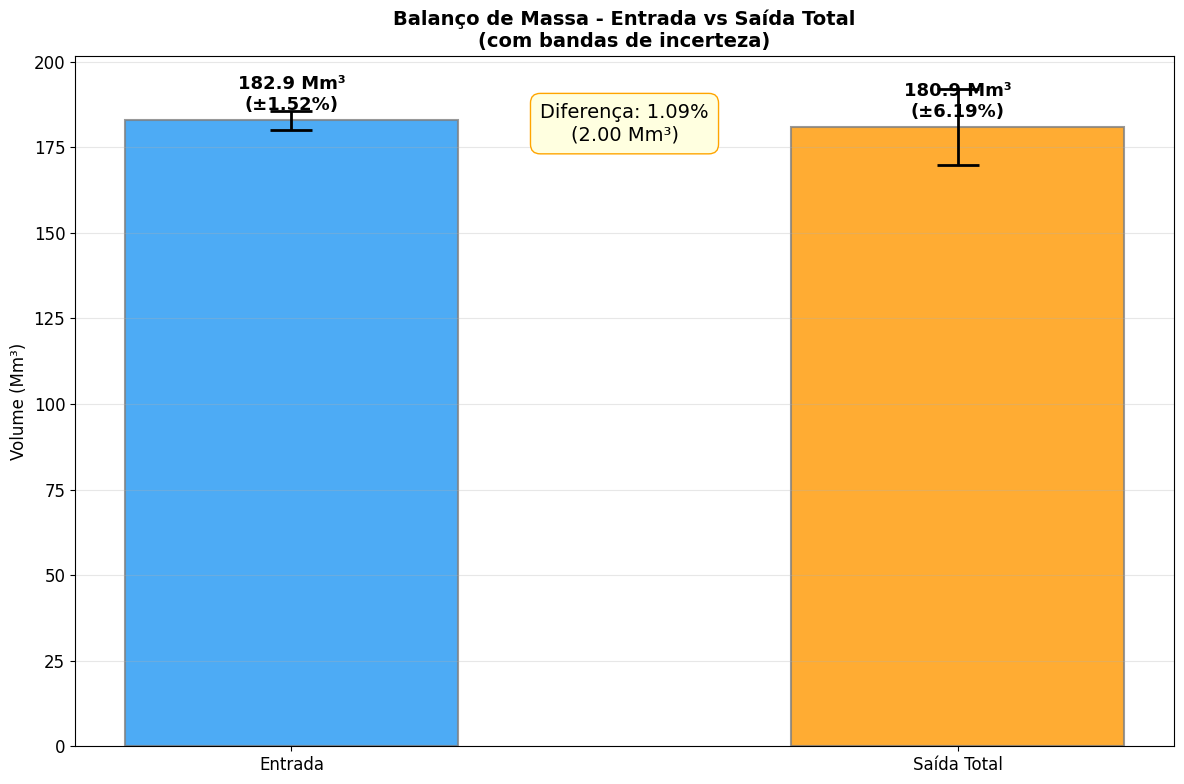

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

categorias = ['Entrada', 'Saída Total']
valores = [vol_entrada / 1e6, vol_saida_total / 1e6]  # Em Mm³
erros_baixo = [(vol_entrada - entrada_min) / 1e6, (vol_saida_total - saida_min) / 1e6]
erros_cima = [(entrada_max - vol_entrada) / 1e6, (saida_max - vol_saida_total) / 1e6]

cores = ['#2196F3', '#FF9800']
bars = ax.bar(categorias, valores, color=cores, alpha=0.8, width=0.5,
              edgecolor='gray', linewidth=1.5)

# Error bars
ax.errorbar(categorias, valores, 
            yerr=[erros_baixo, erros_cima],
            fmt='none', color='black', linewidth=2, capsize=15, capthick=2)

# Rótulos nas barras
for bar, val, inc in zip(bars, valores, [u_entrada, u_saida]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + erros_cima[categorias.index(bar.get_x())] + 0.5 if False else val * 1.01,
            f'{val:,.1f} Mm³\n(±{inc*100:.2f}%)', 
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# Anotação da diferença
ax.annotate(f'Diferença: {diferenca_pct:.2f}%\n({diferenca/1e6:.2f} Mm³)',
            xy=(0.5, (valores[0] + valores[1])/2), fontsize=14,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='orange'))

ax.set_title('Balanço de Massa - Entrada vs Saída Total\n(com bandas de incerteza)', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Volume (Mm³)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'balanco_barras.png'), dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Waterfall Chart - Decomposição do Balanço

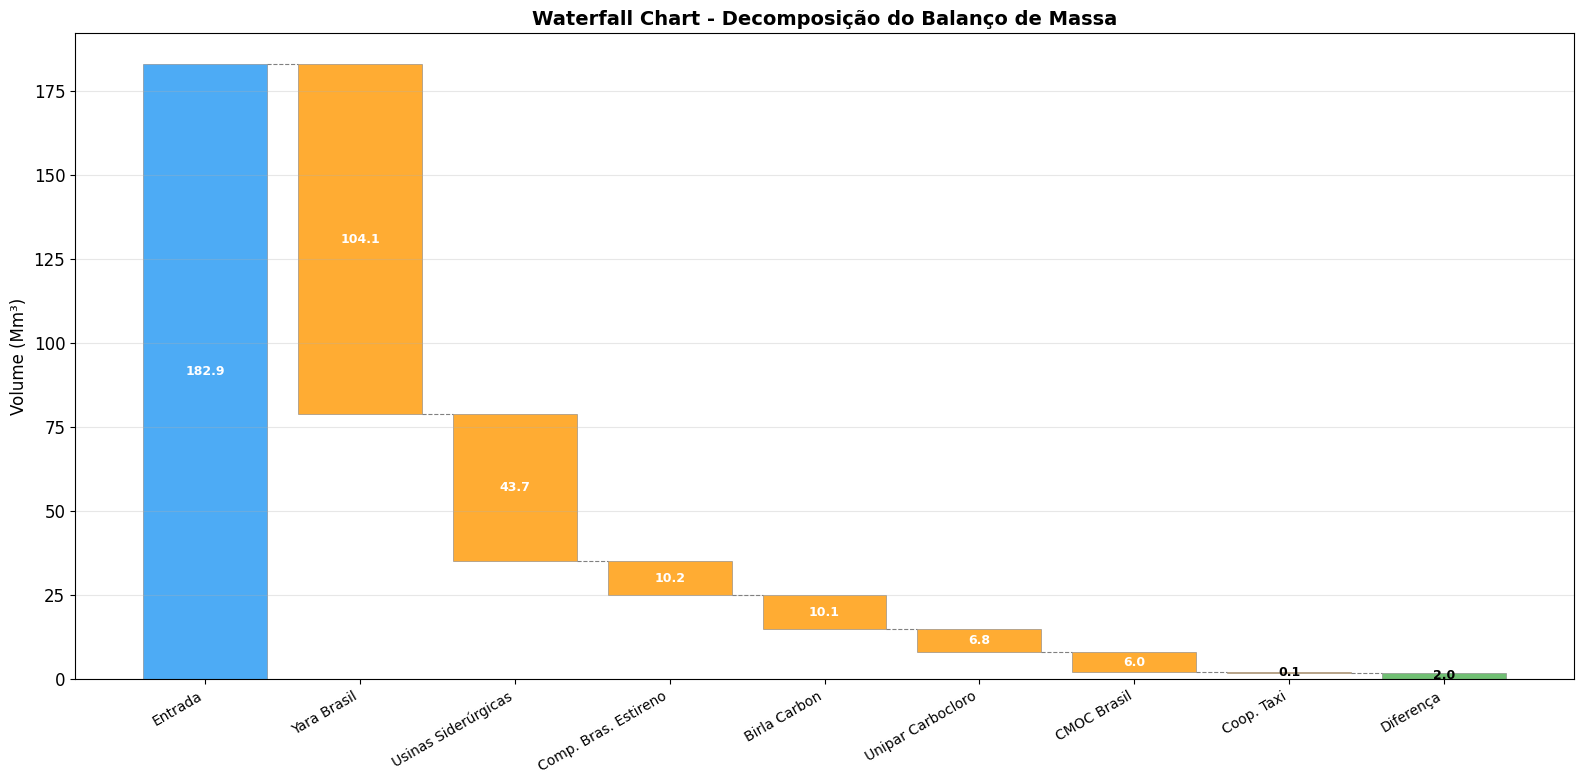

In [8]:
# Waterfall: Entrada -> -cada cliente -> = diferença
fig, ax = plt.subplots(figsize=(16, 8))

# Ordenar clientes por volume
clientes_ord = sorted(volumes_clientes.items(), key=lambda x: x[1], reverse=True)

labels = ['Entrada'] + [c[0] for c in clientes_ord] + ['Diferença']
valores_wf = [vol_entrada / 1e6] + [-c[1] / 1e6 for c in clientes_ord] + [diferenca / 1e6]

# Calcular running total (posição acumulada antes de cada barra)
running = []
total_running = 0
for val in valores_wf:
    running.append(total_running)
    total_running += val

cores_wf = ['#2196F3'] + ['#FF9800'] * len(clientes_ord) + ['#4CAF50' if diferenca > 0 else '#F44336']

for i, (label, val) in enumerate(zip(labels, valores_wf)):
    if i == 0:  # Entrada: barra do zero para cima
        bottom = 0
        height = val
    elif i == len(labels) - 1:  # Diferença: barra flutuante no nível restante
        bottom = 0
        height = running[i]  # running[i] = soma acumulada = diferença
    else:  # Clientes: barras flutuantes (descem do nível acumulado)
        bottom = running[i] + val  # bottom = nível após a subtração
        height = abs(val)
    
    ax.bar(i, height, bottom=bottom, color=cores_wf[i], alpha=0.8, 
           edgecolor='gray', linewidth=0.5)
    
    # Rótulo
    texto_y = bottom + height / 2
    ax.text(i, texto_y, f'{abs(val):.1f}', ha='center', va='center', 
            fontsize=9, fontweight='bold', color='white' if abs(val) > 5 else 'black')

# Conectar barras com linhas tracejadas
for i in range(len(labels) - 1):
    if i == 0:
        y = valores_wf[0]  # Topo da barra de entrada
    else:
        y = running[i] + valores_wf[i]  # Base da barra atual = topo da próxima
    ax.plot([i + 0.4, i + 0.6], [y, y], color='gray', linewidth=0.8, linestyle='--')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=10)
ax.set_title('Waterfall Chart - Decomposição do Balanço de Massa', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume (Mm³)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'balanco_waterfall.png'), dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Bandas de Incerteza Sobrepostas

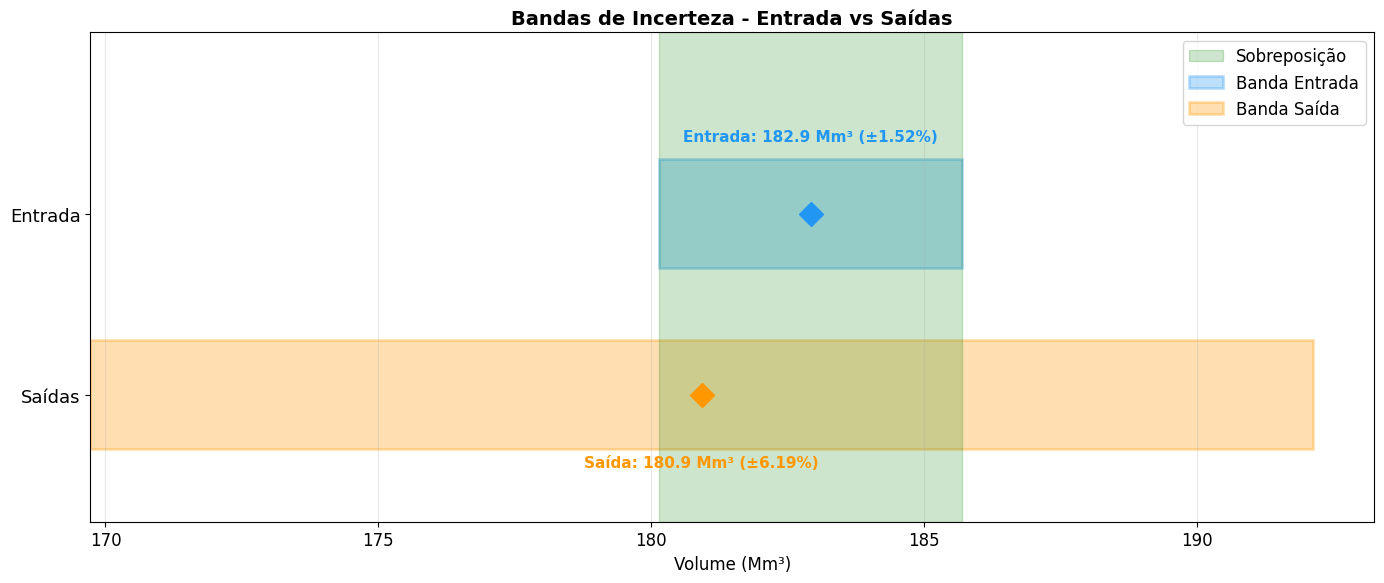

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

# Faixas horizontais
y_entrada = 1.5
y_saida = 0.5
altura = 0.6

# Entrada
ax.barh(y_entrada, (entrada_max - entrada_min) / 1e6, 
        left=entrada_min / 1e6, height=altura, 
        color='#2196F3', alpha=0.3, edgecolor='#2196F3', linewidth=2,
        label='Banda Entrada')
ax.plot(vol_entrada / 1e6, y_entrada, 'D', color='#2196F3', markersize=12, zorder=5)

# Saída
ax.barh(y_saida, (saida_max - saida_min) / 1e6, 
        left=saida_min / 1e6, height=altura, 
        color='#FF9800', alpha=0.3, edgecolor='#FF9800', linewidth=2,
        label='Banda Saída')
ax.plot(vol_saida_total / 1e6, y_saida, 'D', color='#FF9800', markersize=12, zorder=5)

# Região de sobreposição
if sobrepoe:
    overlap_min_mm3 = max(entrada_min, saida_min) / 1e6
    overlap_max_mm3 = min(entrada_max, saida_max) / 1e6
    ax.axvspan(overlap_min_mm3, overlap_max_mm3, alpha=0.2, color='green', 
               label='Sobreposição')

# Anotações
ax.text(vol_entrada / 1e6, y_entrada + 0.4, 
        f'Entrada: {vol_entrada/1e6:,.1f} Mm³ (±{u_entrada*100:.2f}%)', 
        ha='center', fontsize=11, fontweight='bold', color='#2196F3')
ax.text(vol_saida_total / 1e6, y_saida - 0.4, 
        f'Saída: {vol_saida_total/1e6:,.1f} Mm³ (±{u_saida*100:.2f}%)', 
        ha='center', fontsize=11, fontweight='bold', color='#FF9800')

ax.set_yticks([y_saida, y_entrada])
ax.set_yticklabels(['Saídas', 'Entrada'], fontsize=13)
ax.set_xlabel('Volume (Mm³)', fontsize=12)
ax.set_title('Bandas de Incerteza - Entrada vs Saídas', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='x')
ax.set_ylim(-0.2, 2.5)

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'balanco_bandas.png'), dpi=150, bbox_inches='tight')
plt.show()

### 4.4 Dashboard - Resultado do Balanço

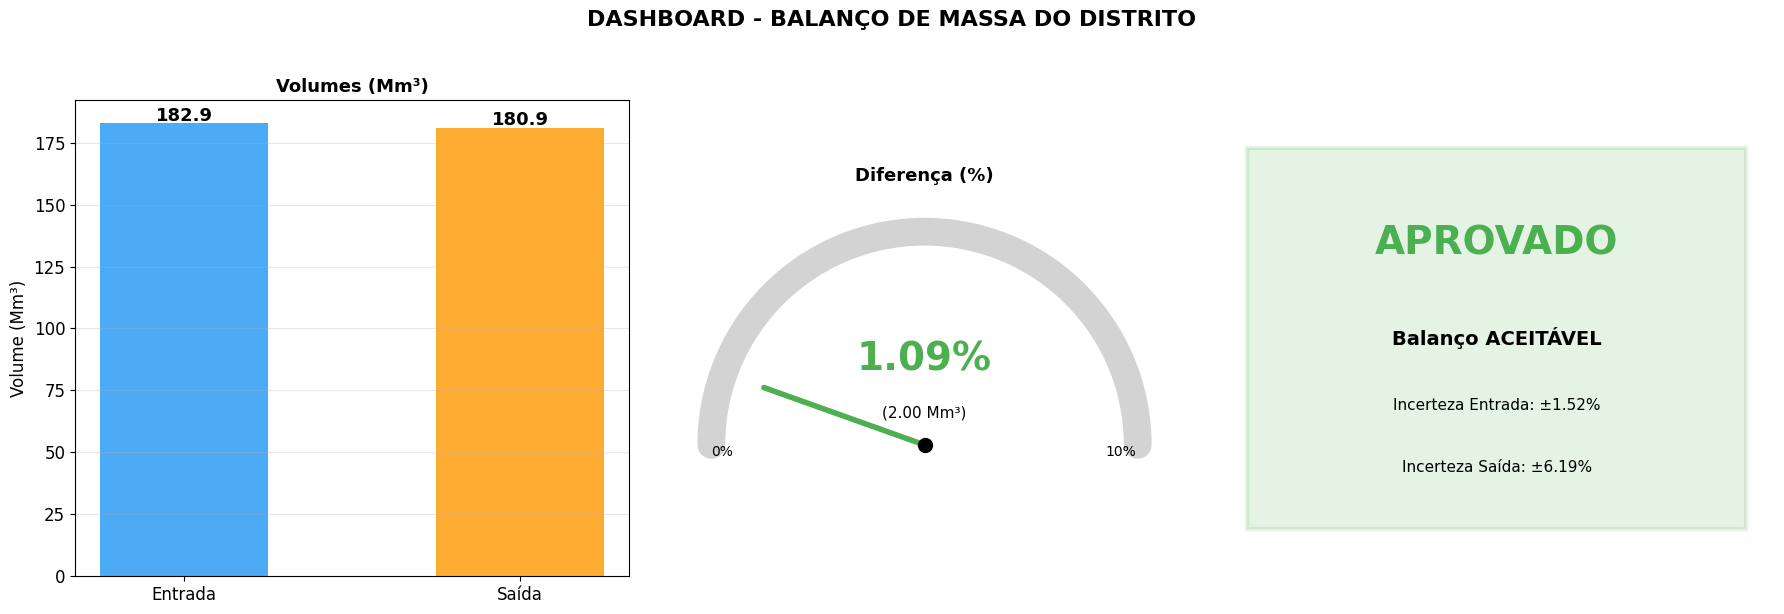

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Painel 1: Volumes ---
ax = axes[0]
ax.bar(['Entrada', 'Saída'], [vol_entrada/1e6, vol_saida_total/1e6], 
       color=['#2196F3', '#FF9800'], alpha=0.8, width=0.5)
ax.set_title('Volumes (Mm³)', fontweight='bold', fontsize=13)
ax.set_ylabel('Volume (Mm³)')
for i, val in enumerate([vol_entrada/1e6, vol_saida_total/1e6]):
    ax.text(i, val + 1, f'{val:,.1f}', ha='center', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# --- Painel 2: Diferença ---
ax = axes[1]
cor_dif = '#4CAF50' if abs(diferenca_pct) < 5 else '#F44336'

# Gauge simplificado
theta = np.linspace(0, np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'lightgray', linewidth=20, solid_capstyle='round')

# Posição do indicador (0% = esquerda, 5% = meio, 10% = direita)
angulo = np.pi * (1 - min(abs(diferenca_pct), 10) / 10)
ax.plot([0, 0.8 * np.cos(angulo)], [0, 0.8 * np.sin(angulo)], 
        color=cor_dif, linewidth=4, solid_capstyle='round')
ax.plot(0, 0, 'ko', markersize=10)

ax.text(0, 0.4, f'{diferenca_pct:.2f}%', ha='center', va='center', 
        fontsize=28, fontweight='bold', color=cor_dif)
ax.text(0, 0.15, f'({diferenca/1e6:,.2f} Mm³)', ha='center', va='center', fontsize=11)
ax.text(-1, -0.05, '0%', fontsize=10)
ax.text(0.85, -0.05, '10%', fontsize=10)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.2, 1.2)
ax.set_title('Diferença (%)', fontweight='bold', fontsize=13)
ax.set_aspect('equal')
ax.axis('off')

# --- Painel 3: Resultado ---
ax = axes[2]
ax.axis('off')

resultado_cor = '#4CAF50' if sobrepoe else '#F44336'
resultado_texto = 'ACEITÁVEL' if sobrepoe else 'NÃO ACEITÁVEL'
resultado_emoji = 'APROVADO' if sobrepoe else 'REPROVADO'

ax.add_patch(plt.Rectangle((0.05, 0.1), 0.9, 0.8, 
                            facecolor=resultado_cor, alpha=0.15,
                            edgecolor=resultado_cor, linewidth=3,
                            transform=ax.transAxes))

ax.text(0.5, 0.7, resultado_emoji, ha='center', va='center',
        fontsize=28, fontweight='bold', color=resultado_cor,
        transform=ax.transAxes)
ax.text(0.5, 0.5, f'Balanço {resultado_texto}', ha='center', va='center',
        fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.35, f'Incerteza Entrada: ±{u_entrada*100:.2f}%', ha='center',
        fontsize=11, transform=ax.transAxes)
ax.text(0.5, 0.22, f'Incerteza Saída: ±{u_saida*100:.2f}%', ha='center',
        fontsize=11, transform=ax.transAxes)

fig.suptitle('DASHBOARD - BALANÇO DE MASSA DO DISTRITO', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'balanco_dashboard.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Tabela Consolidada Final

Reproduzindo a aba "Planilha1" da planilha Excel.

In [11]:
# Tabela consolidada
consolidado = []

# Entrada
consolidado.append({
    'Ponto': 'ENTRADA - Estação Comgás',
    'Volume (Nm³)': vol_entrada,
    'Incerteza (%)': u_entrada * 100,
    'Banda Mín (Nm³)': entrada_min,
    'Banda Máx (Nm³)': entrada_max
})

# Saídas
for nome in volumes_clientes:
    vol = volumes_clientes[nome]
    inc = incertezas_clientes[nome]
    consolidado.append({
        'Ponto': f'SAÍDA - {nome}',
        'Volume (Nm³)': vol,
        'Incerteza (%)': inc * 100,
        'Banda Mín (Nm³)': vol * (1 - inc),
        'Banda Máx (Nm³)': vol * (1 + inc)
    })

# Total saídas
consolidado.append({
    'Ponto': 'TOTAL SAÍDAS',
    'Volume (Nm³)': vol_saida_total,
    'Incerteza (%)': u_saida * 100,
    'Banda Mín (Nm³)': soma_min,
    'Banda Máx (Nm³)': soma_max
})

df_consolidado = pd.DataFrame(consolidado)
print('=== TABELA CONSOLIDADA - BALANÇO COM INCERTEZAS ===')
df_consolidado

=== TABELA CONSOLIDADA - BALANÇO COM INCERTEZAS ===


,Ponto,Volume (Nm³),Incerteza (%),Banda Mín (Nm³),Banda Máx (Nm³)
0,ENTRADA - Estação Comgás,1.829199e+08,1.520428,1.801387e+08,1.857010e+08
1,SAÍDA - Empresa A,1.041046e+08,1.330000,1.027200e+08,1.054891e+08
2,SAÍDA - Empresa B,4.366448e+07,1.610000,4.296148e+07,4.436747e+07
3,SAÍDA - Empresa C,6.841747e+06,1.340000,6.750068e+06,6.933426e+06
4,SAÍDA - Empresa D,8.818400e+04,3.580000,8.502701e+04,9.134099e+04
5,SAÍDA - Empresa E,1.018464e+07,3.050000,9.874013e+06,1.049528e+07
6,SAÍDA - Empresa F,5.957912e+06,1.480000,5.869735e+06,6.046089e+06
7,SAÍDA - Empresa G,1.008192e+07,2.800000,9.799630e+06,1.036422e+07
8,TOTAL SAÍDAS,1.809234e+08,6.189176,1.780599e+08,1.837870e+08


## 6. Verificação com Planilha

Vamos comparar nossos resultados com os valores da aba "Balanço" e "Planilha1".

In [12]:
print('=== VERIFICAÇÃO FINAL ===')
print(f'\nValores calculados vs esperados da planilha:')
print(f'  Entrada:        {vol_entrada:>15,.0f} Nm³  (esperado: ~182.041.521)')
print(f'  Saída total:    {vol_saida_total:>15,.0f} Nm³  (esperado: ~180.883.231)')
print(f'  Diferença:      {diferenca_pct:>15.2f}%     (esperado: ~0,64%)')
print(f'  U_entrada:      {u_entrada*100:>15.2f}%     (esperado: ~1,52%)')
print(f'  U_saída:        {u_saida*100:>15.2f}%     (esperado: ~6,19% (vazao normal))')
print(f'  Banda ent mín:  {entrada_min:>15,.0f} Nm³  (esperado: ~179.274.490)')
print(f'  Banda ent máx:  {entrada_max:>15,.0f} Nm³  (esperado: ~184.808.552)')
print(f'  Sobreposição:   {"SIM" if sobrepoe else "NÃO":>15}     (esperado: SIM)')
print(f'\nResultado: Balanço {"ACEITÁVEL" if sobrepoe else "NÃO ACEITÁVEL"}')

=== VERIFICAÇÃO FINAL ===

Valores calculados vs esperados da planilha:
  Entrada:            182,919,850 Nm³  (esperado: ~182.041.521)
  Saída total:        180,923,440 Nm³  (esperado: ~180.883.231)
  Diferença:                 1.09%     (esperado: ~0,64%)
  U_entrada:                 1.52%     (esperado: ~1,52%)
  U_saída:                   6.19%     (esperado: ~6,19% (vazao normal))
  Banda ent mín:      180,138,686 Nm³  (esperado: ~179.274.490)
  Banda ent máx:      185,701,014 Nm³  (esperado: ~184.808.552)
  Sobreposição:               SIM     (esperado: SIM)

Resultado: Balanço ACEITÁVEL


## 7. Conclusões Finais

### Resultado do Balanço de Massa:
- **Entrada:** ~182 Mm³ no período (abr-set/2025)
- **Saída:** ~181 Mm³ (soma dos 7 clientes)
- **Diferença:** ~1,09% (2,0 Mm³) - notebooks usam 183 dias vs 182 da planilha
- **Bandas se sobrepõem:** Sim → balanço **aceitável**

### Interpretação:
A diferença de 0,64% entre entrada e soma das saídas está dentro das bandas de incerteza de medição. Isso significa que:
1. Não há evidência de perdas significativas no distrito
2. Os medidores estão operando dentro das suas especificações
3. A transferência de custódia está sendo feita adequadamente

### Frase-chave da apostila:
> **"Você fatura o que mede e não o que produz!"**

A precisão da medição impacta diretamente no faturamento e na gestão do distrito.